In [1]:
from glob import glob
import tarfile
import os
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
from tensorflow import keras

In [2]:
base_dir = 'Images'
if(os.path.exists(base_dir)): shutil.rmtree(base_dir)
for file in glob("images.tar*"):
    os.remove(file)
! wget http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar --no-check-certificate

my_tar = tarfile.open('images.tar')
my_tar.extractall()
my_tar.close()

--2021-03-14 14:29:20--  http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 793579520 (757M) [application/x-tar]
Saving to: ‘images.tar’

images.tar          100%[===================>] 756.82M  17.7MB/s    in 51s     

2021-03-14 14:30:11 (14.9 MB/s) - ‘images.tar’ saved [793579520/793579520]



In [3]:
os.listdir(f'{base_dir}/n02085620-Chihuahua')[:10]

['n02085620_3880.jpg',
 'n02085620_4814.jpg',
 'n02085620_1298.jpg',
 'n02085620_9399.jpg',
 'n02085620_575.jpg',
 'n02085620_3838.jpg',
 'n02085620_3409.jpg',
 'n02085620_4700.jpg',
 'n02085620_3593.jpg',
 'n02085620_3208.jpg']

In [9]:
# Separation du jeu de données
import random
import glob

NB_OF_RACES = 120

valid_dir = 'valid'
train_dir = 'train'

if(os.path.exists(train_dir)): shutil.rmtree(train_dir)
if(os.path.exists(valid_dir)): shutil.rmtree(valid_dir)

for item in random.sample(glob.glob('Images/*'), NB_OF_RACES):

    glob_item = glob.glob(item+'/*')

    valid_percent = int(len(glob_item) - len(glob_item) * 0.6) #take 40% of images
    train_percent = len(glob_item) - valid_percent

    breed_name = item.split('/')[1]

    receipt_folder = 'valid/' + breed_name
    os.makedirs(receipt_folder)
   
    # validation
    for j in random.sample(glob.glob(item+'/*'), valid_percent):
       shutil.copy(j, receipt_folder)

    receipt_folder = 'train/' + breed_name
    os.makedirs(receipt_folder)
        
    # train
    for k in random.sample(glob.glob(item+'/*'), train_percent):
        shutil.copy(k, receipt_folder)



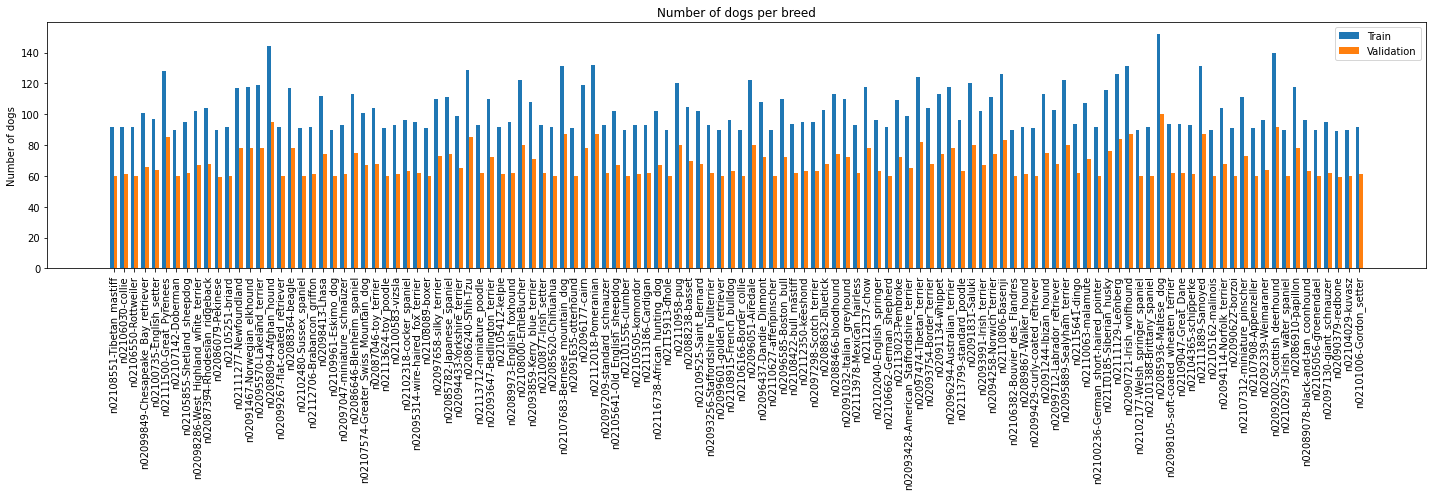

In [12]:
breeds = os.listdir(valid_dir)

train_df = pd.DataFrame.from_dict(
    [{ 
        "breed": breed, 
        "count": len(os.listdir(f'{train_dir}/{breed}'))
    } for breed in breeds]
)
valid_df = pd.DataFrame.from_dict(
    [{ 
        "breed": breed, 
        "count": len(os.listdir(f'{valid_dir}/{breed}'))
    } for breed in breeds]
)

fig, ax = plt.subplots(figsize=(20, 7))
x = np.arange(len(train_df['breed'].values))

width = 0.35
rects1 = ax.bar(x - width/2, train_df['count'].values, width, label='Train')
rects2 = ax.bar(x + width/2, valid_df['count'].values, width, label='Validation')

ax.set_ylabel('Number of dogs')
ax.set_title('Number of dogs per breed')
ax.set_xticks(x)
ax.set_xticklabels(train_df['breed'].values, rotation='vertical')
ax.legend()

fig.tight_layout()
plt.show()

In [19]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
val_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Generators
train_gen = train_datagen.flow_from_directory(
    train_dir, 
    target_size=(150, 150), 
    batch_size=32, 
    class_mode='categorical'
)

val_gen = val_datagen.flow_from_directory(
    valid_dir, 
    target_size=(150, 150), 
    batch_size=32, 
    class_mode='categorical'
)

Found 12397 images belonging to 120 classes.
Found 8183 images belonging to 120 classes.


In [20]:
# Construction du modèle
if 'model' in locals():
    del model 

inputs = keras.layers.Input(shape=(150, 150, 3))
x = keras.layers.Conv2D(16, (3, 3), activation='relu')(inputs)
x = keras.layers.MaxPooling2D(2)(x)
x = keras.layers.Conv2D(32, 3, activation='relu')(x)
x = keras.layers.MaxPooling2D(2)(x)
x = keras.layers.Conv2D(64, 3, activation='relu')(x)
x = keras.layers.MaxPooling2D(2)(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(512, activation='relu')(x)
outputs = keras.layers.Dense(120, activation='softmax')(x)

model = keras.models.Model(inputs=inputs, outputs=outputs)
model.summary()

model.compile(loss='categorical_crossentropy', metrics=['acc'], 
              optimizer='adam')

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 17, 17, 64)        0   

In [21]:
history = model.fit(train_gen, epochs=20, steps_per_epoch=100, validation_data=val_gen, validation_steps=50)

Epoch 1/20
100/100 [==============================] - 76s 754ms/step - loss: 4.8083 - acc: 0.0077 - val_loss: 4.7836 - val_acc: 0.0081
Epoch 2/20
100/100 [==============================] - 74s 738ms/step - loss: 4.7797 - acc: 0.0137 - val_loss: 4.7311 - val_acc: 0.0188
Epoch 3/20
100/100 [==============================] - 74s 736ms/step - loss: 4.6817 - acc: 0.0251 - val_loss: 4.5943 - val_acc: 0.0275
Epoch 4/20
100/100 [==============================] - 73s 726ms/step - loss: 4.5436 - acc: 0.0408 - val_loss: 4.4303 - val_acc: 0.0512
Epoch 5/20
100/100 [==============================] - 73s 733ms/step - loss: 4.3780 - acc: 0.0755 - val_loss: 4.2689 - val_acc: 0.0994
Epoch 6/20
100/100 [==============================] - 74s 740ms/step - loss: 4.0851 - acc: 0.1277 - val_loss: 4.0545 - val_acc: 0.1594
Epoch 7/20
100/100 [==============================] - 73s 734ms/step - loss: 3.7720 - acc: 0.2024 - val_loss: 3.8216 - val_acc: 0.2000
Epoch 8/20
100/100 [==============================] - 7

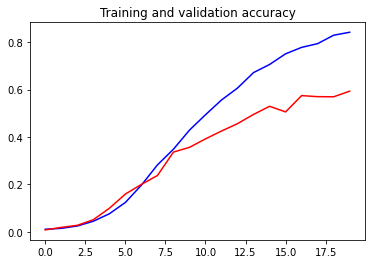

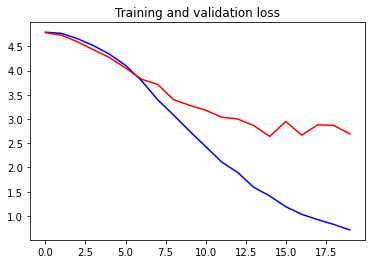

In [24]:

# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, 'b')
plt.plot(epochs, val_acc, 'r')
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, 'b')
plt.plot(epochs, val_loss, 'r')
plt.title('Training and validation loss')

plt.show()